"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [24]:
#https://discourse.pymc.io/t/nuts-uses-all-cores/909/9


import os
os.environ["MKL_NUM_THREADS"]='1'
os.environ["OMP_NUM_THREADS"]='1'

In [2]:
base_dir = '/media/bigdata/projects/pytau'
import sys
sys.path.append(base_dir)
import pytau.changepoint_model as models

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Using directory: /media/bigdata/projects/pytau//pytau/how_to/examples/saved_models


In [3]:
import pickle
import scipy.stats as stats
import pymc as pm
import pytensor.tensor as tt
import numpy as np
import pylab as plt
import arviz as az
import pandas as pd
import seaborn as sns

In [25]:

def gen_lambda():
    lambda_multipliers = np.random.random(states) * rate_scaler
    true_lambda = np.random.random((nrns,states))
    true_lambda = true_lambda * lambda_multipliers[np.newaxis,:]
    return true_lambda

def return_trial_dat(true_lambda):
    true_tau = np.cumsum(np.random.random(states))
    true_tau /= np.max(true_tau)
    true_tau *= length
    true_tau = np.vectorize(int)(true_tau)
    state_inds = np.concatenate([np.zeros((1)),true_tau])
    state_inds = np.vectorize(int)(state_inds)
    true_tau = true_tau[:-1]

    true_r = np.zeros((nrns,length))
    for num, val in enumerate(true_lambda.T):
        true_r[:,state_inds[num]:state_inds[num+1]] = val[:,np.newaxis]

    #data_array = np.random.random(true_r.shape) < true_r
    data_array = np.random.poisson(true_r)
    return true_r, data_array

def return_poisson_data():
    true_lambda = gen_lambda()
    trial_list = [return_trial_dat(true_lambda) for i in range(trial_count)]
    r_list, spike_list = list(zip(*trial_list))
    r_array, spike_array = np.stack(r_list), np.stack(spike_list)
    return r_array, spike_array

def return_poisson_data_switch(n_trial_states = 2):
    trial_fracs = np.cumsum(np.random.random(n_trial_states))
    trial_fracs = trial_fracs / trial_fracs.max()
    trial_inds = np.vectorize(int)(trial_fracs * trial_count)
    trial_inds = np.concatenate([[0], trial_inds])
    trial_sections = [(trial_inds[i], trial_inds[i+1]) for i in range(len(trial_inds)-1)]
    r_array_list = []
    spike_array_list = []
    for this_section in trial_sections:
        true_lambda = gen_lambda()
        trial_list = [return_trial_dat(true_lambda) for i in range(trial_count)]
        r_list, spike_list = list(zip(*trial_list))
        r_array, spike_array = np.stack(r_list), np.stack(spike_list)
        r_array_list.append(r_array[this_section[0]:this_section[1]])
        spike_array_list.append(spike_array[this_section[0]:this_section[1]])
    fin_r_array = np.concatenate(r_array_list, axis = 0)
    fin_spike_array = np.concatenate(spike_array_list, axis = 0)
    return fin_r_array, fin_spike_array, trial_sections

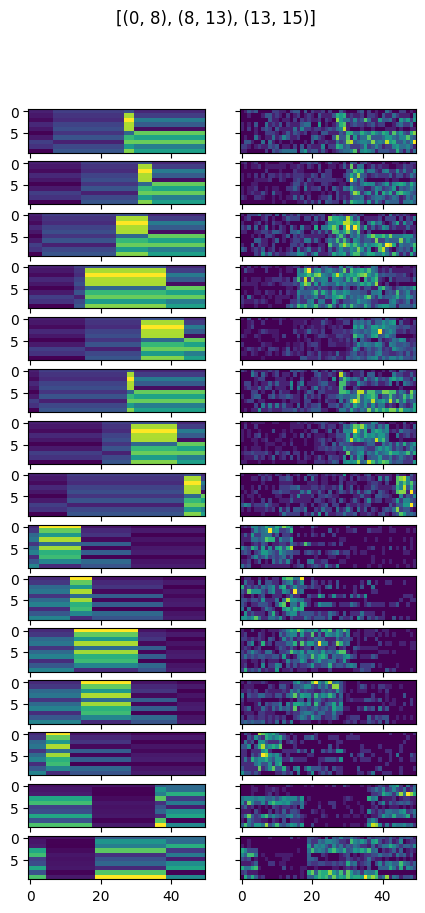

In [54]:
# Some poisson spiking
length = 50
states = 4
nrns = 10
trial_count = 15
idx = np.arange(length)
rate_scaler = 10
trial_switches = 3

r_array, spike_array, trial_sections = return_poisson_data_switch(trial_switches)

fig, ax = plt.subplots(trial_count,2, 
                       sharex=True, sharey=True,
                      figsize = (5,10))
fig.suptitle(trial_sections)

for i in range(trial_count):
    ax[i,0].imshow(r_array[i],aspect='auto', interpolation='nearest');
    ax[i,1].imshow(spike_array[i],aspect='auto', interpolation='nearest');

In [55]:
# ! cat /media/bigdata/projects/pytau/pytau/changepoint_model.py

In [56]:
def stick_breaking(beta):
    portion_remaining = tt.concatenate(
        [[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

In [57]:
def single_taste_poisson_dpp_trial_switch(
        spike_array,
        switch_components,
        states):
    """
    Assuming only emissions change across trials
    Changepoint distribution remains constant

    spike_array :: trials x nrns x time
    states :: number of states to include in the model 
    """

    trial_num, nrn_num, time_bins = spike_array.shape
    
    with pm.Model() as model:
    
            # Define Emissions
    
            # nrns
            nrn_lambda = pm.Exponential('nrn_lambda', 10, shape=(nrn_num))
    
            # nrns x switch_comps
            trial_lambda = pm.Exponential('trial_lambda',
                                          nrn_lambda.dimshuffle(0, 'x'),
                                          shape=(nrn_num, switch_components))
    
            # nrns x switch_comps x states
            state_lambda = pm.Exponential('state_lambda',
                                          trial_lambda.dimshuffle(0, 1, 'x'),
                                          shape=(nrn_num, switch_components, states))
            # Define Changepoints
            # Assuming distribution of changepoints remains
            # the same across all trials
    
            a = pm.HalfCauchy('a_tau', 3., shape=states - 1)
            b = pm.HalfCauchy('b_tau', 3., shape=states - 1)
    
            even_switches = np.linspace(0, 1, states+1)[1:-1]
            tau_latent = pm.Beta('tau_latent', a, b,
                                 # testval=even_switches,
                                 shape=(trial_num, states-1)).sort(axis=-1)
    
            # Trials x Changepoints
            tau = pm.Deterministic('tau', time_bins * tau_latent)
    
            # Hyperpriors on alpha
            a_gamma = pm.Gamma('a_gamma', 10, 1)
            b_gamma = pm.Gamma('b_gamma', 1.5, 1)
    
            # Concentration parameter for beta
            alpha = pm.Gamma('alpha', a_gamma, b_gamma)
    
            # Draw beta's to calculate stick lengths
            beta = pm.Beta('beta', 1, alpha, shape=switch_components)
    
            # Calculate stick lengths using stick_breaking process
            w_raw = pm.Deterministic('w_raw', stick_breaking(beta))
    
            # Make sure lengths add to 1, and scale to length of data
            tau_trial_latent = pm.Deterministic('w_latent', tt.cumsum(w_raw / w_raw.sum())[:-1])
            # w_latent = pm.Deterministic('w_latent', w_raw / w_raw.sum())
            # tau = pm.Deterministic('tau', tt.cumsum(w_latent * length)[:-1])
    
            # Trial_changepoints
            tau_trial = pm.Deterministic('tau_trial', trial_num * tau_trial_latent)
    
            trial_idx = np.arange(trial_num)
            trial_selector = tt.math.sigmoid(
                trial_idx[np.newaxis, :] - tau_trial.dimshuffle(0, 'x'))
    
            trial_selector = tt.concatenate(
                [np.ones((1, trial_num)), trial_selector], axis=0)
            inverse_trial_selector = 1 - trial_selector[1:, :]
            inverse_trial_selector = tt.concatenate([inverse_trial_selector,
                                                    np.ones((1, trial_num))], axis=0)
    
            # First, we can "select" sets of emissions depending on trial_changepoints
            # switch_comps x trials
            trial_selector = np.multiply(trial_selector, inverse_trial_selector)
    
            # state_lambda: nrns x switch_comps x states
    
            # selected_trial_lambda : nrns x states x trials
            selected_trial_lambda = pm.Deterministic('selected_trial_lambda',
                                                     tt.sum(
                                                         # "nrns" x switch_comps x "states" x trials
                                                         trial_selector.dimshuffle(
                                                             'x', 0, 'x', 1) * state_lambda.dimshuffle(0, 1, 2, 'x'),
                                                         axis=1)
                                                     )
    
            # Then, we can select state_emissions for every trial
            idx = np.arange(time_bins)
    
            # tau : Trials x Changepoints
            weight_stack = tt.math.sigmoid(
                idx[np.newaxis, :]-tau[:, :, np.newaxis])
            weight_stack = tt.concatenate(
                [np.ones((trial_num, 1, time_bins)), weight_stack], axis=1)
            inverse_stack = 1 - weight_stack[:, 1:]
            inverse_stack = tt.concatenate(
                [inverse_stack, np.ones((trial_num, 1, time_bins))], axis=1)
    
            # Trials x states x Time
            weight_stack = np.multiply(weight_stack, inverse_stack)
    
            # Convert selected_trial_lambda : nrns x trials x states x "time"
    
            # nrns x trials x time
            lambda_ = tt.sum(selected_trial_lambda.dimshuffle(0, 2, 1, 'x') * weight_stack.dimshuffle('x', 0, 1, 2),
                             axis=2)
    
            # Convert to : trials x nrns x time
            lambda_ = lambda_.dimshuffle(1, 0, 2)
    
            # Add observations
            observation = pm.Poisson("obs", lambda_, observed=spike_array)

    return model

In [58]:
# with model:
#     prior_samples = pm.sample_prior_predictive(var_names = ['tau_trial'], samples = 10000)

# plt.hist(prior_samples.prior['tau_trial'].values.flatten(), bins = 50);

In [59]:
model = single_taste_poisson_dpp_trial_switch(
        spike_array,
        switch_components = 3,
        states = states)

In [60]:
# pm.model_to_graphviz(model)

In [66]:
n_chains = 24
dpp_trace = models.dpp_fit(model, n_cores = int(np.min([n_chains, 24])), 
                           n_chains = n_chains, use_numpyro=True,
                          tune = 125, draws = 125)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [62]:
# with model:
#         inference = pm.ADVI('full-rank')
#         approx = pm.fit(n=int(1e5), method=inference)
#         dpp_trace = approx.sample(draws=int(2e4))

Output()

Finished [100%]: Average Loss = 12,606


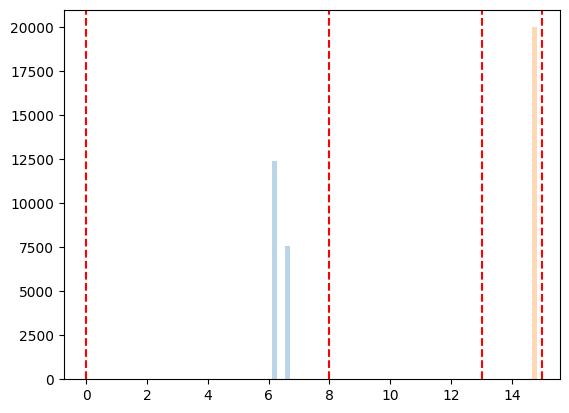

In [67]:
tau_trial_samples = dpp_trace.posterior['tau_trial'].values
# reshaped_tau_trial = np.reshape(tau_trial_samples, (n_chains, -1))
# reshaped_tau_trial = tau_trial_samples.copy()
for this_chain in reshaped_tau_trial:
    plt.hist(this_chain, bins = 20, alpha = 0.3);
for val in np.unique([x for y in trial_sections for x in y]):
    plt.axvline(val, color = 'red', linestyle = '--')

In [68]:
tau_trial_samples.shape

(24, 125, 2)

In [69]:
with model:
    ppc_samples = pm.sample_posterior_predictive(dpp_trace, extend_inferencedata=False)

Sampling: [obs]


Output()

In [70]:
mean_ppc = ppc_samples.posterior_predictive.obs.values.mean(axis=(0,1))

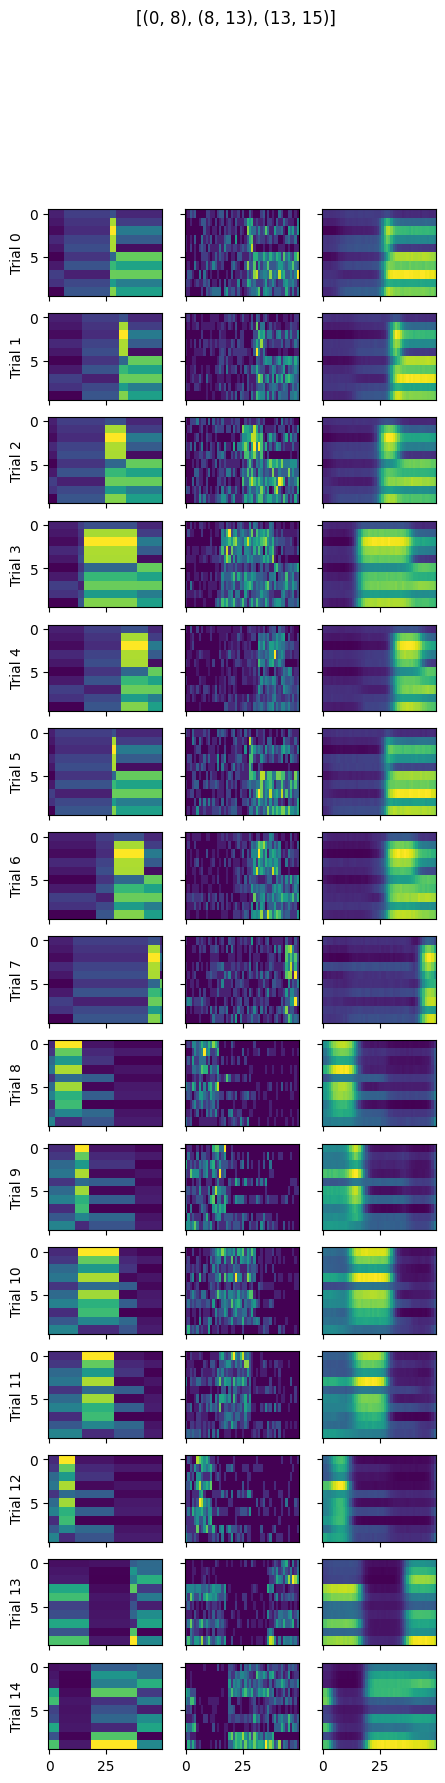

In [71]:
fig, ax = plt.subplots(trial_count,3, 
                       sharex=True, sharey=True,
                      figsize = (5,20))
fig.suptitle(trial_sections)
for i in range(trial_count):
    ax[i,0].imshow(r_array[i],aspect='auto', interpolation='nearest');
    ax[i,1].imshow(spike_array[i],aspect='auto', interpolation='nearest');
    ax[i,2].imshow(mean_ppc[i],aspect='auto', interpolation='nearest');
    ax[i,0].set_ylabel(f'Trial {i}')